In [1]:
using Colladas
using UrbanMaps
using RayCasters
using MapPlot
using Distributions

INFO: Loading help data...


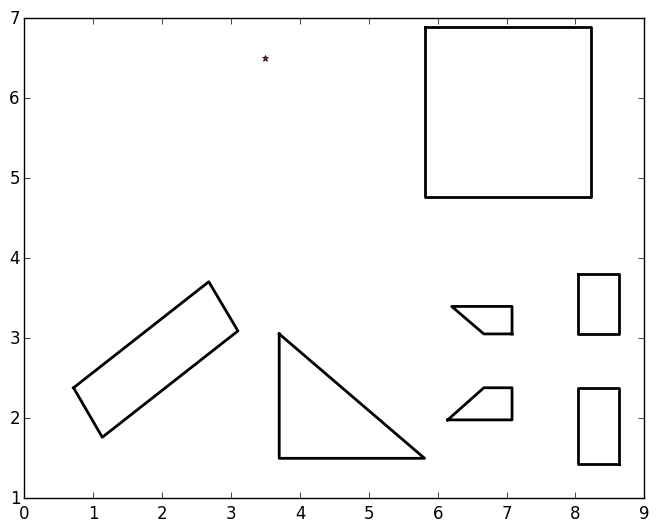

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1172fee50>

In [2]:
coll = ColladaObjects("demo_map_border2D.dae")
map = UrbanMap(coll, 10, 10);
plot(map)
plot([3.5],[6.5],"*",color="r",markersize=5.0)

## Robot Model

Dynamics are linear with Gaussian noise:

$x_{k} = A x_{k-1} + B u_{k-1} + v_{k-1}$

Robot can only measure the straighline distance between itself and the nearest object (or boundary) in the -y direction. Measurements are noisy and Gaussian. 

In [40]:
type RobotModel
    A::Matrix{Float64}
    B::Matrix{Float64}
    # can be sigma values
    process_noise::Normal
    observation_noise::Normal
    map::UrbanMap
end

typealias State Vector{Float64} # x,y position
typealias Action Vector{Float64} # x,y control
typealias Observation Float64 # distance to nearest wall in -y direction

# generative model
function move(m::RobotModel, x::State, u::Action)
    pn = m.process_noise
    sp = m.A*x + m.B*u + rand(pn, 2)
end

# observation function
function observation(m::RobotModel, o::Observation, x::State, u::Action)
    map = m.map
    if inBuilding(map, x)
        return 0.0
    end
    if 0.0 <= x[1] <= 9.0 && 0.0 <= x[2] <= 7.0
        return 0.0
    end
    on = params(m.observation_noise)[2]
    d = nearest_wall(map, x, :down)
    n = Normal(d, on)
    return pdf(n, o)
end

function observe(m::RobotModel, x::State)
    on = m.observation_noise
    d = nearest_wall(m.map, x, :down) + rand(on)
end


observe (generic function with 1 method)

In [4]:
type Belief
    particles::Matrix{Float64}
    temp_particles::Matrix{Float64}
    weights::Vector{Float64}
    temp_weights::Vector{Float64}
    n::Int64
end

function rand!(x::Vector{Float64}, b::Belief)
    i = rand(1:b.n)
    x[1:end] = b.particles[:,i]
end

function update_belief!(b::Belief, m::RobotModel, u::Action, o::Observation)
    n = b.n
    x = zeros(2)
    weights = b.temp_weights
    particles = b.temp_particles
    for i = 1:n
        rand!(x, b)
        xp = move(m, x, u)
        weights[i] = observation(m, o, xp, u)
        particles[:,i] = xp
    end
    norm = sum(weights)
    for i = 1:n; weights[i] /= norm; end;
    dist = Categorical(weights)
    updated_weights = b.weights
    updated_particles = b.particles
    for i = 1:n
        k = rand(dist)
        updated_weights[i] = weights[k]
        updated_particles[:,i] = particles[:,k]
    end
    b
end


function update_positions!(b::Belief, m::RobotModel, u::Action)
    for i = 1:b.n
        x = particles[]
        xp = move(m, ) 
    end
end

function add_noise!(b::Belief)
    particles = b.paticles
    for i = 1:b.n
        particles[1,i] += rand() 
    end
end

function PyPlot.plot(b::Belief)
    n = b.n
    par = b.particles
    weights = b.weights
    norm = maximum(weights)
    for i = 1:n
        ms = 10.0 * weights[i]/norm
        plot(par[1,i], par[2,i], ".", color="r",markersize=5.0) 
    end
end

plot (generic function with 3 methods)

In [42]:
A = eye(2)
B = eye(2)
pn = Normal(0.0, 0.1)
on = Normal(0.0, 0.2)
robot = RobotModel(A, B, pn, on, map);


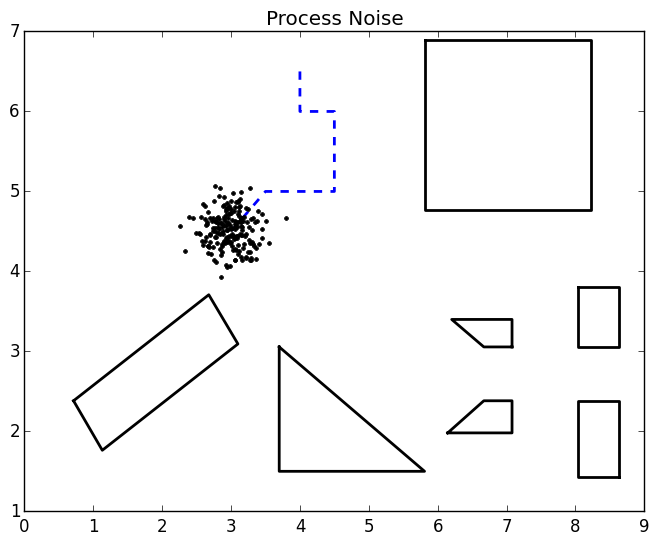

PyObject <matplotlib.text.Text object at 0x1232b5f50>

In [52]:
us = {[0.0,-0.5], [0.5,0.0], [0.0,-0.5,], [0.0,-0.5], [-1.0,0.0], [-0.5,-0.5]}
x0 = [4.0,6.5]
trajectory = [[4.0, 4.0, 4.5, 4.5, 4.5, 3.5, 3.0] [6.5, 6.0, 6.0, 5.5, 5.0, 5.0, 4.5]]
ns = 200
xf = zeros(2,ns)
for i = 1:ns
    x = deepcopy(x0)
    for j = 1:length(us)
        u = us[j]
        x = move(robot, x, u)
    end
    xf[:,i] = x
end
plot(map)
plot(vec(trajectory[:,1]),vec(trajectory[:,2]),"--",lw=2.0,color="b")
plot(vec(xf[1,:]),vec(xf[2,:]),".",color="k")
title("Process Noise")

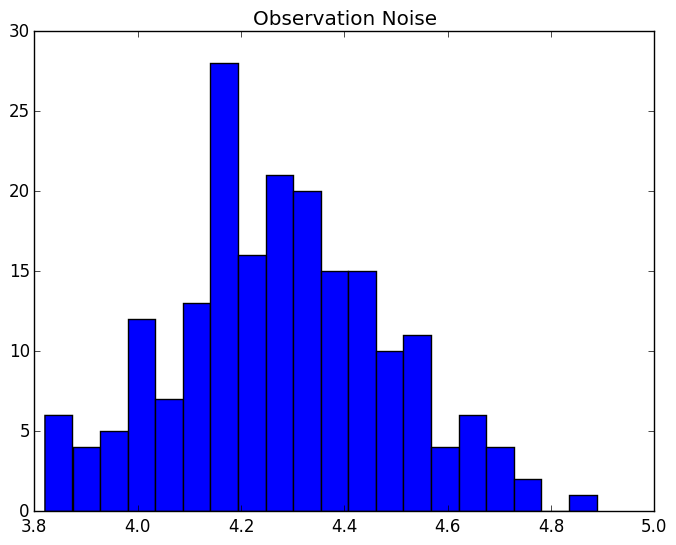

PyObject <matplotlib.text.Text object at 0x128891ad0>

In [51]:
of = zeros(ns)
for i = 1:ns
    of[i] = observe(robot, x0)
end
fig = figure(facecolor="white")
ax = fig[:add_subplot](111)
ax[:hist](of,bins=20)
title("Observation Noise")


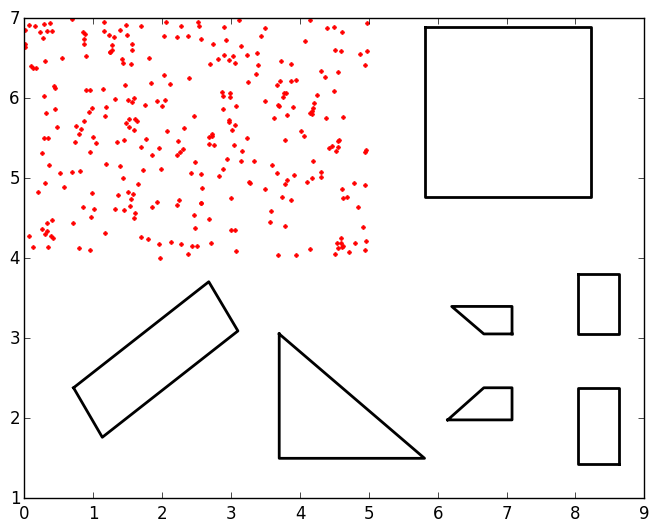

In [14]:
ns = 300
p0 = zeros(2,ns)
x_d = Uniform(0,5)
y_d = Uniform(4,7)
for i = 1:ns
    p0[1,i] = rand(x_d)
    p0[2,i] = rand(y_d)
end
w0 = zeros(ns) + 1.0/ns
b = Belief(p0, p0, w0, w0, ns);
plot(map)
plot(b)

Slider{Int64}([Input{Int64}] 6,"l",6,1:11)

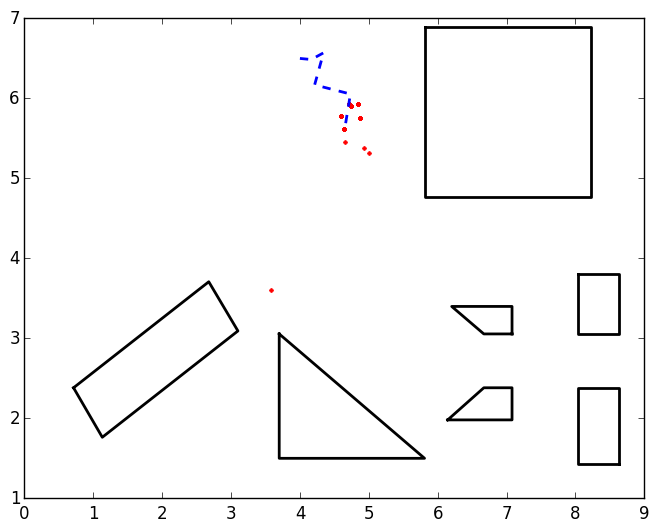

In [41]:
using Interact
using PyPlot

A = eye(2)
B = eye(2)
pn = Normal(0.0, 0.1)
on = Normal(0.0, 0.2)
robot = RobotModel(A, B, pn, on, map);


x = [4.0,6.5]
us = {[0.0, 0.0], [0.0,0.0], [0.0,-0.5], [0.5,0.0], [0.0,-0.5,], [0.0,-0.5], [-1.0,0.0], [-0.5,-0.5], [-0.5, 0.0], [0.0, 0.0], [0.0, 0.0]}
n_steps = length(us)
trajectory = zeros(2,n_steps)

ns = 500
p0 = zeros(2,ns)
x_d = Uniform(0,5)
y_d = Uniform(4,7)
for i = 1:ns
    p0[1,i] = rand(x_d)
    p0[2,i] = rand(y_d)
end
w0 = zeros(ns) + 1.0/ns
b = Belief(p0, p0, w0, w0, ns);
beliefs = Belief[]
for i = 1:n_steps
    push!(beliefs, deepcopy(b))
    trajectory[:,i] = x
    u = us[i]
    x = move(robot, x, u)
    obs = observe(robot,x)
    update_belief!(b, robot, u, obs)
end

fig = figure(facecolor="white")

@manipulate for l = 1:n_steps; withfig(fig) do
    b = beliefs[l]
    ax = fig[:add_subplot](111)
    plot(map)
    plot(b)
    #plot(trajectory[1,l], trajectory[1,l], "o", color="b", markersize=5.0)
    plot(vec(trajectory[1,1:l]),vec(trajectory[2,1:l]),"--",lw=2.0,color="b")
    #plot(map,b,trajectory)->(plot(map), plot(b),plot(vec(trajectory[1,1:l]),vec(trajectory[2,1:l]),"--",lw=2.0,color="b"))
end
end
